# Machine Vision Lab 8
> Name - Ojas Patil
>
> Register Number - 21BAI1106

> Alternatively, you can find the colab ntoebook [here](https://colab.research.google.com/drive/1sCuJwoTH5rgHWwDLFjkkFV0VrkoqRB7l?usp=sharing).

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import os
from IPython.display import clear_output

### Load Video
you can find the video here ma'am - [gdrive](https://drive.google.com/file/d/1RN0UNFdzM0M_K-fwp27YfhjFCdtYKYNb/view?usp=sharing)

In [8]:
video_path = '/content/mv_demo.mp4'

cap = cv2.VideoCapture(video_path)

# video properteis for fun
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(f"FPS: {fps}")
print(f"Total Frames: {frame_count}")
print(f"Resolution: {width}x{height}")

FPS: 30
Total Frames: 200
Resolution: 1920x1080


### Frame Extractions and Storing

In [9]:
def extract_frames(cap):
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    return frames

# Extract all frames
frames = extract_frames(cap)
print(f"Extracted {len(frames)} frames")

cap.release()

Extracted 200 frames


### Spatio-temporal Segmentation

In [10]:
def segment_frame(frame):
    # Convert to HSV for better color segmentation
    hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)

    lower = np.array([0, 30, 30])
    upper = np.array([180, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)

    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    return mask

# Perform segmentation on all frames
segmented_frames = [segment_frame(frame) for frame in frames]

### Cut Scene Detection

In [11]:
def compute_histogram(frame):
    hist = cv2.calcHist([cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)],
                        [0], None, [256], [0, 256])
    return hist.flatten() / hist.sum()

def detect_scene_cuts(frames, threshold_hard=0.3, threshold_soft=0.1):
    scene_cuts = []
    soft_cuts = []

    for i in range(1, len(frames)):
        # Compute histograms
        hist1 = compute_histogram(frames[i-1])
        hist2 = compute_histogram(frames[i])

        # Calculate difference
        diff = np.sum(np.abs(hist1 - hist2))

        # Detect cuts
        if diff > threshold_hard:
            scene_cuts.append(('hard', i))
        elif diff > threshold_soft:
            soft_cuts.append(('soft', i))

    return scene_cuts + soft_cuts


# Detect scene cuts
scene_transitions = detect_scene_cuts(frames)
print(f"Detected {len(scene_transitions)} scene transitions")

Detected 1 scene transitions


## Visualizing Results

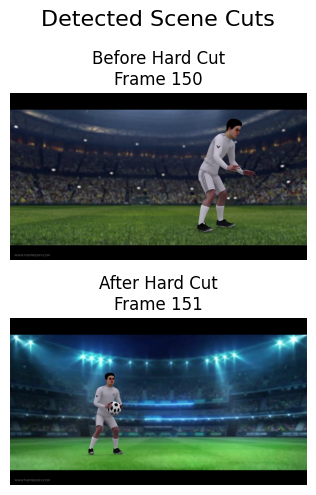

In [12]:
def visualize_scene_cuts(frames, scene_transitions):
    if not scene_transitions:
        print("No scene transitions detected!")
        return

    num_cuts = min(6, len(scene_transitions))
    fig = plt.figure(figsize=(20, 5))
    fig.suptitle('Detected Scene Cuts', fontsize=16)

    for idx, (cut_type, frame_idx) in enumerate(scene_transitions[:num_cuts]):
        # Show frame before cut
        plt.subplot(2, num_cuts, idx + 1)
        plt.imshow(frames[max(0, frame_idx-1)])
        plt.title(f'Before {cut_type.capitalize()} Cut\nFrame {max(0, frame_idx-1)}')
        plt.axis('off')

        # Show frame after cut
        plt.subplot(2, num_cuts, idx + num_cuts + 1)
        plt.imshow(frames[frame_idx])
        plt.title(f'After {cut_type.capitalize()} Cut\nFrame {frame_idx}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Visualize scene cuts
visualize_scene_cuts(frames, scene_transitions)

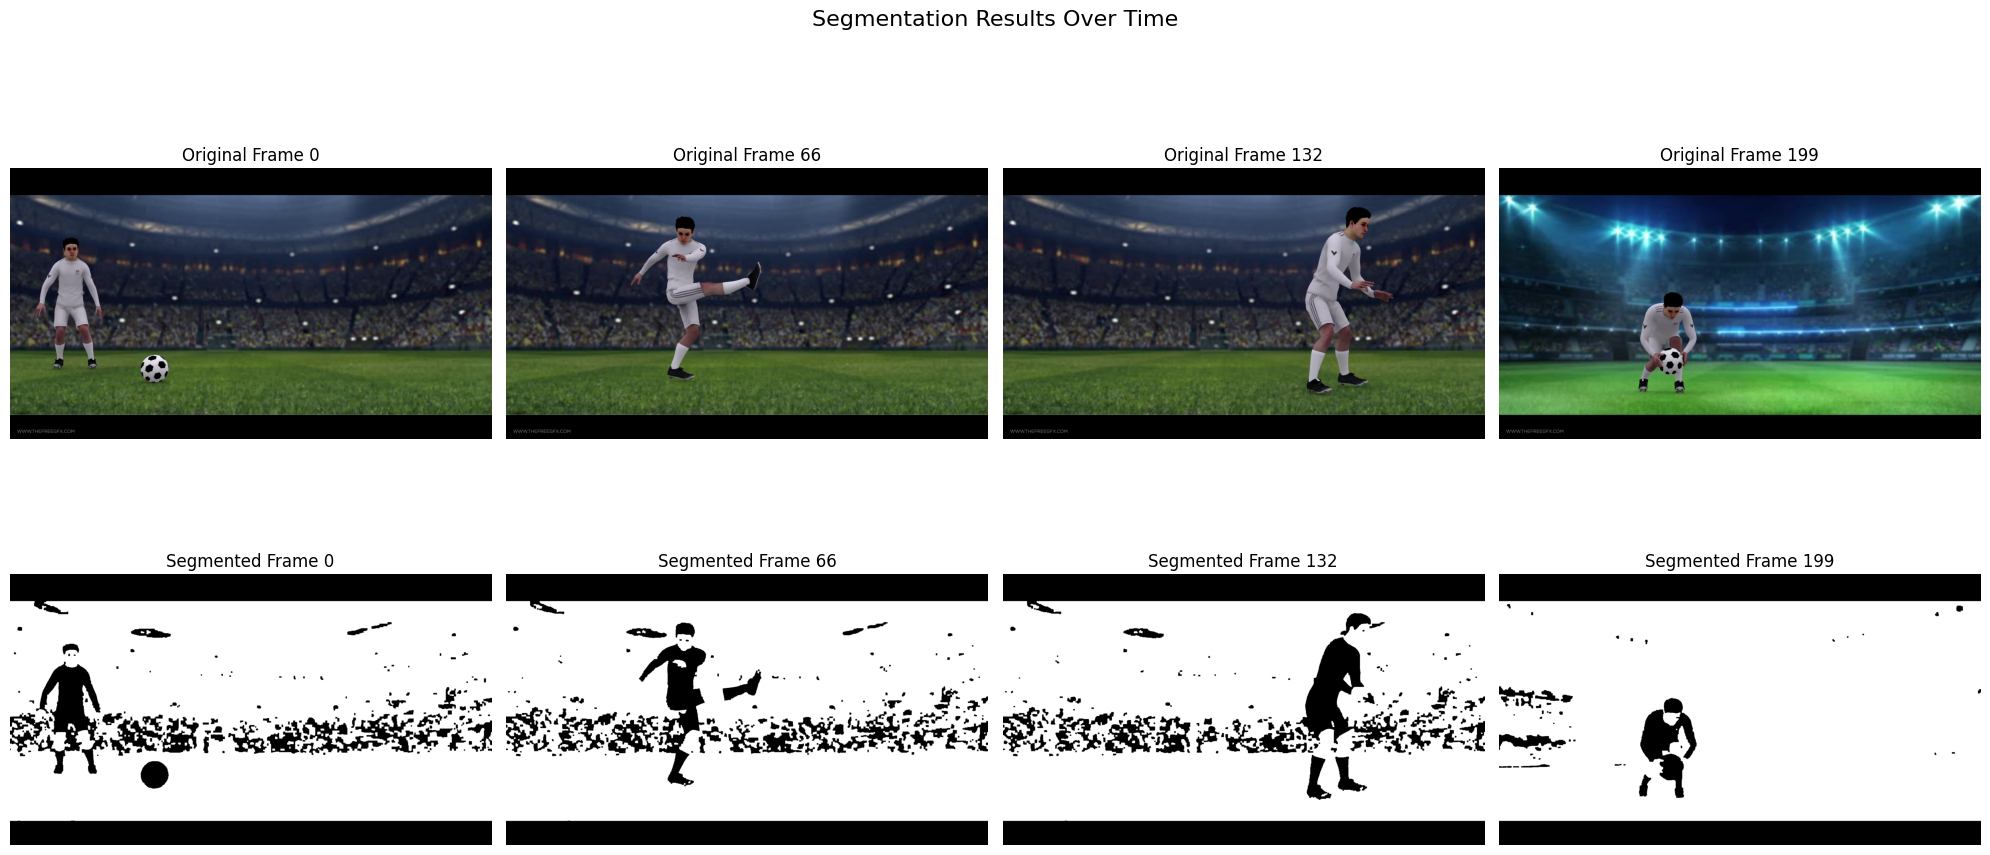

In [13]:
def visualize_segmentation_sequence(frames, segmented_frames, num_frames=4):
    # Select evenly spaced frames
    total_frames = len(frames)
    frame_indices = np.linspace(0, total_frames-1, num_frames, dtype=int)

    # Create figure
    plt.figure(figsize=(20, 10))
    plt.suptitle('Segmentation Results Over Time', fontsize=16)

    for idx, frame_idx in enumerate(frame_indices):
        # Original frame
        plt.subplot(2, num_frames, idx + 1)
        plt.imshow(frames[frame_idx])
        plt.title(f'Original Frame {frame_idx}')
        plt.axis('off')

        # Segmented frame
        plt.subplot(2, num_frames, idx + num_frames + 1)
        plt.imshow(segmented_frames[frame_idx], cmap='gray')
        plt.title(f'Segmented Frame {frame_idx}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize segmentation results
visualize_segmentation_sequence(frames, segmented_frames, num_frames=4)